In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import catboost as cb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

In [8]:
cb.__version__

'1.0.6'

In [5]:
import xgboost;xgboost.__version__

'1.5.0'

In [9]:
# Mine

import sklearn
sklearn.__version__

'1.1.1'

## 设置与读取

In [14]:
import warnings
warnings.filterwarnings('ignore')

# 显示单元格的所有输出

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

## 设置与读取

In [4]:
train_data = pd.read_csv('../raw_data/train_public.csv')
submit_example = pd.read_csv('../raw_data/submit_example.csv')
test_public = pd.read_csv('../raw_data/test_public.csv')
train_inte = pd.read_csv('../raw_data/train_internet.csv')

pd.options.display.max_columns = None
pd.options.display.max_rows = 200
pd.options.display.float_format = lambda x: '%.3f' % x

In [14]:
train_inte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loan_id                   750000 non-null  int64  
 1   user_id                   750000 non-null  int64  
 2   total_loan                750000 non-null  float64
 3   year_of_loan              750000 non-null  int64  
 4   interest                  750000 non-null  float64
 5   monthly_payment           750000 non-null  float64
 6   class                     750000 non-null  object 
 7   sub_class                 750000 non-null  object 
 8   work_type                 750000 non-null  object 
 9   employer_type             750000 non-null  object 
 10  industry                  750000 non-null  object 
 11  work_year                 706153 non-null  object 
 12  house_exist               750000 non-null  int64  
 13  house_loan_status         750000 non-null  i

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   10000 non-null  int64  
 1   user_id                   10000 non-null  int64  
 2   total_loan                10000 non-null  float64
 3   year_of_loan              10000 non-null  int64  
 4   interest                  10000 non-null  float64
 5   monthly_payment           10000 non-null  float64
 6   class                     10000 non-null  object 
 7   employer_type             10000 non-null  object 
 8   industry                  10000 non-null  object 
 9   work_year                 9378 non-null   object 
 10  house_exist               10000 non-null  int64  
 11  censor_status             10000 non-null  int64  
 12  issue_date                10000 non-null  object 
 13  use                       10000 non-null  int64  
 14  post_co

### 探索性分析

In [19]:
train_data[['earlies_credit_mon']]

,earlies_credit_mon
0,1-Dec
1,Apr-90
2,Oct-91
3,1-Jun
4,2-May
...,...
9995,6-Feb
9996,May-97
9997,Feb-87
9998,Oct-92


In [21]:
test_public[['earlies_credit_mon']]

,earlies_credit_mon
0,3-Mar
1,Dec-99
2,Apr-99
3,Jul-00
4,7-May
...,...
4995,5-Jul
4996,12-Apr
4997,Oct-86
4998,Mar-99


In [ ]:
train_inte['work_year'].value_counts()

# train_inte['work_year'].nunique(dropna=False)

# train_inte[train_inte['work_year'].isnull()]

 10    246226
 2      67987
 0      60198
 3      60128
 1      49204
 5      47027
 4      45037
-1      43847
 6      34910
 8      33857
 7      33200
 9      28379
Name: work_year, dtype: int64

In [9]:
train_inte['is_default'].value_counts()

0    600327
1    149673
Name: is_default, dtype: int64

In [6]:
train_data['isDefault'].value_counts()

0    8317
1    1683
Name: isDefault, dtype: int64

### 获取缺失值情况

In [19]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[          # 找出含缺失值的列并按缺失值的多少由大到小排序
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [38]:
missing_values_table(train_data)

Your selected dataframe has 44 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
f1,858,8.600
f0,498,5.000
f2,498,5.000
f3,498,5.000
f4,498,5.000
pub_dero_bankrup,7,0.100


<AxesSubplot:>

<AxesSubplot:xlabel='f1', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f0', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f2', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f3', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f4', ylabel='Density'>

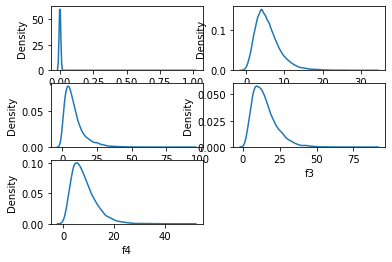

In [45]:
# 查看数据分布

import seaborn as sns
from seaborn import kdeplot       

plt.subplot(3,2,1)
kdeplot(data=train_data,x="f1")
plt.subplot(3,2,2)
kdeplot(data=train_data,x="f0")
plt.subplot(3,2,3)
kdeplot(data=train_data,x="f2")
plt.subplot(3,2,4)
kdeplot(data=train_data,x="f3")
plt.subplot(3,2,5)
kdeplot(data=train_data,x="f4")

In [42]:
train_data["f1"].median()
train_data["f1"].mode()
train_data["f1"].mean()

0.0

0   0.000
Name: f1, dtype: float64

0.0014220083132793699

In [ ]:
missing_values_table(test_public)
missing_values_table(train_inte)

Your selected dataframe has 43 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
f1,454,9.100
f0,259,5.200
f2,259,5.200
f3,259,5.200
f4,259,5.200
pub_dero_bankrup,4,0.100


Your selected dataframe has 47 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
f1,65411,8.700
f3,37799,5.000
f0,37798,5.000
f2,37798,5.000
f4,37798,5.000
f5,37798,5.000
recircle_u,489,0.100
pub_dero_bankrup,375,0.000
debt_loan_ratio,230,0.000
post_code,1,0.000


<AxesSubplot:>

<AxesSubplot:xlabel='f1', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f0', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f2', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f3', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f4', ylabel='Density'>

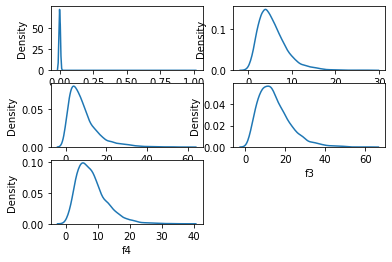

In [46]:
# 查看数据分布

import seaborn as sns
from seaborn import kdeplot       

plt.subplot(3,2,1)
kdeplot(data=test_public,x="f1")
plt.subplot(3,2,2)
kdeplot(data=test_public,x="f0")
plt.subplot(3,2,3)
kdeplot(data=test_public,x="f2")
plt.subplot(3,2,4)
kdeplot(data=test_public,x="f3")
plt.subplot(3,2,5)
kdeplot(data=test_public,x="f4")

<AxesSubplot:>

<AxesSubplot:xlabel='f1', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f0', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f2', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f3', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f4', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='f5', ylabel='Density'>

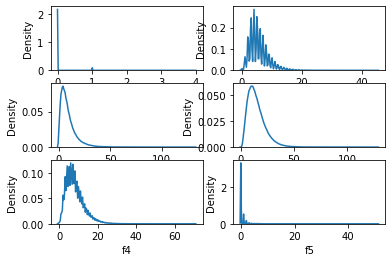

In [47]:
# 查看数据分布

import seaborn as sns
from seaborn import kdeplot       

plt.subplot(3,2,1)
kdeplot(data=train_inte,x="f1")
plt.subplot(3,2,2)
kdeplot(data=train_inte,x="f0")
plt.subplot(3,2,3)
kdeplot(data=train_inte,x="f2")
plt.subplot(3,2,4)
kdeplot(data=train_inte,x="f3")
plt.subplot(3,2,5)
kdeplot(data=train_inte,x="f4")
plt.subplot(3,2,6)
kdeplot(data=train_inte,x="f5")

## 模型模块

In [3]:
def train_model(data_, test_, y_, folds_,col_to_excl_from_feats=[]):
    '''
    用catboost模型进行训练
    '''
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] + col_to_excl_from_feats]
    # for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y)):
        # 划分训练集和验证集
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx] 
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]

        cat_model = cb.CatBoostClassifier(iterations=3000, 
                              depth=7, 
                              learning_rate=0.001, 
                              loss_function='Logloss',
                              eval_metric='AUC',
                              logging_level='Verbose', 
                              metric_period=50)

        cat_model.fit(trn_x, trn_y, eval_set=[(trn_x, trn_y), (val_x, val_y)])

        oof_preds[val_idx] = cat_model.predict_proba(val_x)[:, 1] # 更新验证集预测结果
        sub_preds += cat_model.predict_proba(test_[feats])[:, 1] / folds_.n_splits # 更新测试集预测结果
        
        # 更新特征重要性表
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = cat_model.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del cat_model, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

def train_model_lgbm(data_, test_, y_, folds_,col_to_excl_from_feats=[]):
    '''
    用lightgbm模型训练
    '''
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] + col_to_excl_from_feats]
    # for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            # n_estimators=4000,
            n_estimators=200,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

def train_model_xgb(data_, test_, y_, folds_, train_model_loc=None, trained_model_name="xgboost"):
    import pickle
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault']]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx] # 划分训练集和验证集
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        if(train_model_loc is None):
            clf = XGBClassifier(eval_metric='auc', max_depth=5, alpha=0.3, reg_lambda=0.3, subsample=0.8,
                            colsample_bylevel=0.867, objective='binary:logistic', use_label_encoder=False,
                            learning_rate=0.08, n_estimators=4000, min_child_weight=2, tree_method='hist',
                            n_jobs=-1) 
                            # reg_lambda: Defines the degree of L2 regularization 
                            # alpha: Defines the degree of L1 reg on weights
                            # n_estimators: Number of base learners (grad boosted trees)
                            # subsample: Subsample ratio of the training instance
            clf.fit(trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                eval_metric='auc', verbose=100, early_stopping_rounds=40  # 40
                )
            pickle.dump(clf, open(f"../trained_models/{trained_model_name}.pkl","wb"))
        else: # 加载经过预训练的模型
            print("The trained model has been loaded!")
            clf = pickle.load(train_model_loc,"rb")
        oof_preds[val_idx] = clf.predict_proba(val_x, ntree_limit=clf.best_ntree_limit)[:, 1] # Update prediction of the labels in the validation set
        sub_preds += clf.predict_proba(test_[feats], ntree_limit=clf.best_ntree_limit)[:, 1] / folds_.n_splits # Updare prediction of labels in the test set
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]))) # Compare the prediction with the obs in the validation set
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(y_, oof_preds))

    test_['isDefault'] = sub_preds
    return test_[['loan_id', 'isDefault']]

    
def display_importances(feature_importance_df_, fname='lgbm_importances.png'):
    '''
    绘制特征重要性图
    '''
    sns.set(style='whitegrid')
    
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values( # Calculate avg over folds
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{fname.split("_")[0]} Features (avg over folds)')

    # ax = plt.gca()

    ### todo: Set the color of ticks on x and y axes to white
    
    # ax.set_xticklabels(col='white')
    # ax.set_yticklabels(col='white')
    plt.tight_layout()
    plt.savefig(fname)

## 数据预处理

### 特征处理函数

In [17]:
def workYearDIc(x):
    if str(x)=='nan': # Check the ratio of 'nan' entries
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')

In [21]:
#train_test, train_public数据处理
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)

train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))

train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)

train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])




### 缺失值填充

In [ ]:
# Columns containing missing values
set(train_data.columns).difference(train_data.dropna(axis='columns').columns)

{'f0', 'f1', 'f2', 'f3', 'f4', 'pub_dero_bankrup'}

In [22]:
f_feas = ['f0', 'f1', 'f2', 'f3', 'f4'] # f5只在Internet数据中出现，不用于模型训练，不包含

missing_numerical_feas_train_data = list(set(missing_values_table(train_data).reset_index().iloc[:,0]).difference(set(f_feas)))

missing_numerical_feas_test_pub = list(set(missing_values_table(test_public).reset_index().iloc[:,0]).difference(set(f_feas)))

missing_numerical_feas_train_inte = list(set(missing_values_table(train_inte).reset_index().iloc[:,0]).difference(set(f_feas)))

print(missing_numerical_feas_train_data)
print(missing_numerical_feas_test_pub)
print(missing_numerical_feas_train_inte)



Your selected dataframe has 39 columns.
There are 6 columns that have missing values.
Your selected dataframe has 38 columns.
There are 6 columns that have missing values.
Your selected dataframe has 42 columns.
There are 11 columns that have missing values.
['pub_dero_bankrup']
['pub_dero_bankrup']
['f5', 'post_code', 'debt_loan_ratio', 'pub_dero_bankrup', 'title', 'recircle_u']


In [23]:
for col in missing_numerical_feas_train_data:
    train_data[col] = train_data[col].fillna(train_data[col].median())

for col in missing_numerical_feas_test_pub:
    test_public[col] = test_public[col].fillna(test_public[col].median())

train_data.loc[train_data['debt_loan_ratio'] <= 0, 'debt_loan_ratio'] = 0
test_public.loc[test_public['debt_loan_ratio'] <= 0, 'debt_loan_ratio'] = 0

In [24]:
for col in missing_numerical_feas_train_inte:
    if train_inte[col].dtype == "int64" or train_inte[col].dtype == "float64":
        if col == "post_code":
            train_inte["post_code"] = train_inte["post_code"].fillna(train_inte["post_code"].mode()[0])
        else:
            train_inte[col] = train_inte[col].fillna(train_inte[col].median())
train_inte['debt_loan_ratio'] = train_inte['debt_loan_ratio'].apply(lambda x: 0 if x < 0 else x)

In [25]:
train_data[f_feas] = train_data[f_feas].fillna(train_data[f_feas].median())
test_public[f_feas] = test_public[f_feas].fillna(test_public[f_feas].median())
train_inte[f_feas] = train_inte[f_feas].fillna(train_inte[f_feas].median())

In [90]:
missing_values_table(train_data)
missing_values_table(test_public)
missing_values_table(train_inte)

Your selected dataframe has 44 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
work_year,622,6.200


Your selected dataframe has 43 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
work_year,278,5.600


Your selected dataframe has 47 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
work_year,43847,5.800


In [26]:
missing_values_table(train_data)
missing_values_table(test_public)
missing_values_table(train_inte)

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 38 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 42 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [9]:
import copy

df = copy.deepcopy(train_data['earlies_credit_mon'].iloc[:10])

pd.to_datetime(df.map(findDig))

0   2001-12-01
1   1990-04-01
2   1991-10-01
3   2001-06-01
4   2001-05-02
5   1983-01-01
6   2001-10-02
7   2001-10-08
8   1971-11-01
9   2001-12-01
Name: earlies_credit_mon, dtype: datetime64[ns]

### 对抗过拟合-特征粒度处理

### 时间特征

In [27]:
train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


## Pcode 特征

In [8]:
train_data['post_code'].head()

0    193
1    491
2    459
3    157
4     38
Name: post_code, dtype: int64

In [ ]:
train_data['post_code'].min()
train_data['post_code'].max()

0

901

## 精度处理，没有提升，不代表不对

In [28]:
def set_precision(num, n_digits = 3):

    # num = float(num)

    fmt_str = f'.{n_digits}f'
    # print(fmt_str)
    return float(f'{num:{fmt_str}}')

In [ ]:
str(train_inte['total_loan'].dtype)

'float64'

In [57]:
def process(df, func=set_precision, **kwargs) -> pd.DataFrame:
    for col in df:
        if str(df[col].dtype) == 'float64':
            new_col = df[col].apply(set_precision, **kwargs)
            new_col.name = col
            df = df.drop(col, axis=1)
            df[col] = new_col
    return df

In [30]:
train_data = process(train_data, n_digits = 3)
train_data.head()

,loan_id,user_id,year_of_loan,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,del_in_18month,known_outstanding_loan,known_dero,initial_list_status,app_type,earlies_credit_mon,title,policy_code,early_return,early_return_amount,isDefault,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear,total_loan,interest,monthly_payment,debt_loan_ratio,scoring_low,scoring_high,pub_dero_bankrup,recircle_b,recircle_u,f0,f1,f2,f3,f4,early_return_amount_3mon
0,1040418,240418,3,3,政府机构,金融业,3,0,1,2016-10-01,2,193,13,0,3,0,0,0,2001-12-01,5,1,3,9927,0,10,5,12,2001,31818.182,11.466,1174.910,2.430,556.364,649.091,0.000,7734.231,91.800,1.000,0.000,4.000,5.000,4.000,0.000
1,1025197,225197,5,3,政府机构,金融业,10,0,2,2013-06-01,0,491,30,1,3,0,1,0,1990-04-01,40642,1,0,0,0,6,5,4,1990,28000.000,16.841,670.690,11.005,715.000,893.750,0.000,31329.000,54.800,7.000,0.000,4.000,45.000,22.000,0.000
2,1009360,209360,3,1,政府机构,公共服务、社会组织,10,1,0,2014-01-01,4,459,8,0,5,0,1,0,1991-10-01,154,1,0,0,0,1,2,10,1991,17272.727,8.900,603.320,6.409,774.545,903.636,0.000,18514.000,57.692,6.000,0.000,6.000,28.000,19.000,0.000
3,1039708,239708,3,1,世界五百强,文化和体育业,6,0,1,2015-07-01,0,157,8,0,3,0,0,0,2001-06-01,0,1,0,0,0,7,2,6,2001,20000.000,4.788,602.300,9.205,750.000,875.000,0.000,20707.000,42.600,5.000,0.000,10.000,15.000,9.000,0.000
4,1027483,227483,3,3,政府机构,信息传输、软件和信息技术服务业,0,2,1,2016-07-01,0,38,21,0,15,0,0,0,2001-05-02,0,1,0,0,0,7,4,5,2001,15272.727,12.790,470.310,15.578,609.091,710.606,0.000,14016.154,30.462,10.000,0.000,6.000,15.000,4.000,0.000


In [31]:
test_public = process(test_public, n_digits=3)

train_inte = process(train_inte, n_digits=3)

In [39]:
### 查看效果
train_inte['total_loan'].head()

0    2890.910
1    7272.730
2   26295.450
3   22690.910
4   14545.450
Name: total_loan, dtype: float64

## 精度处理后添加特征

### 分期付款与贷款总额比率

In [32]:

instalment_loan_ratio = train_data['monthly_payment'] / train_data['total_loan']

train_data['ratio_instalment_loan'] = instalment_loan_ratio


instalment_loan_ratio = test_public['monthly_payment'] / test_public['total_loan']

test_public['ratio_instalment_loan'] = instalment_loan_ratio


instalment_loan_ratio = train_inte['monthly_payment'] / train_inte['total_loan']

train_inte['ratio_instalment_loan'] = instalment_loan_ratio

In [ ]:
train_data['ratio_instalment_loan']

0      0.037
1      0.024
2      0.035
3      0.030
4      0.031
        ... 
9995   0.029
9996   0.034
9997   0.029
9998   0.036
9999   0.034
Name: ratio_instalment_loan, Length: 10000, dtype: float64

## 自然编码

In [33]:
cat_cols = ['employer_type', 'industry']
train_inte[cat_cols].head()

,employer_type,industry
0,普通企业,采矿业
1,普通企业,国际组织
2,上市企业,信息传输、软件和信息技术服务业
3,普通企业,电力、热力生产供应业
4,政府机构,金融业


In [36]:
cat_cols = ['employer_type', 'industry']

for col in cat_cols:

    dummies_train = pd.get_dummies(train_data[col])
    # print(dummies_train.head())
    dummies_test = pd.get_dummies(test_public[col])
    dummies_inte = pd.get_dummies(train_inte[col])

    # 合并虚拟变量和原数据
    train_data = pd.concat([train_data,dummies_train],axis=1)
    test_public = pd.concat([test_public, dummies_test], axis=1)
    train_inte = pd.concat([train_inte, dummies_inte], axis=1)

    # 删除编码前的数据
    del train_data[col]
    del test_public[col]
    del train_inte[col]

In [37]:
train_inte.head()

,loan_id,user_id,year_of_loan,class,sub_class,work_type,work_year,house_exist,house_loan_status,censor_status,marriage,offsprings,issue_date,use,region,early_return,early_return_amount,initial_list_status,earlies_credit_mon,is_default,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear,total_loan,interest,monthly_payment,post_code,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,early_return_amount_3mon,recircle_b,recircle_u,title,policy_code,f0,f1,f2,f3,f4,f5,ratio_instalment_loan,上市企业,世界五百强,幼教与中小学校,政府机构,普通企业,高等教育机构,交通运输、仓储和邮政业,住宿和餐饮业,信息传输、软件和信息技术服务业,公共服务、社会组织,农、林、牧、渔业,制造业,国际组织,建筑业,房地产业,批发和零售业,文化和体育业,电力、热力生产供应业,采矿业,金融业
0,119262,0,5,2,B5,职员,-1,0,0,2,0,0,2015-06-01,0,4,0,0,0,1984-03-01,1,6,0,3,1984,12000.000,11.530,264.100,814.000,5.070,1.000,670.000,674.000,1.000,0.000,3855.000,23.100,0.000,1.000,1.000,0.000,8.000,17.000,8.000,1.000,0.022,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,369815,1,3,3,C3,其他,10,0,1,2,1,3,2010-10-01,2,21,0,0,1,1992-01-01,0,10,4,1,1992,8000.000,13.980,273.350,240.000,15.040,0.000,725.000,729.000,0.000,0.000,118632.000,99.900,94.000,1.000,5.000,0.000,7.000,13.000,7.000,0.000,0.034,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,787833,2,5,4,D2,工人,10,0,0,1,0,0,2016-08-01,0,20,0,0,0,1996-10-01,0,8,0,10,1996,20000.000,17.990,507.760,164.000,17.380,1.000,675.000,679.000,0.000,0.000,15670.000,72.500,0.000,1.000,6.000,0.000,10.000,8.000,3.000,0.000,0.025,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,671675,3,3,2,B1,职员,2,2,0,2,0,0,2013-05-01,4,10,0,0,0,2000-07-01,0,5,2,7,2000,10700.000,10.160,346.070,48.000,27.870,0.000,710.000,714.000,0.000,0.000,18859.000,78.600,41646.000,1.000,3.000,0.000,4.000,11.000,6.000,0.000,0.032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,245160,4,3,2,B1,其他,5,1,2,0,0,0,2017-04-01,4,9,0,0,1,2000-03-01,0,4,5,3,2000,8000.000,8.240,251.580,122.000,3.470,0.000,660.000,664.000,0.000,0.000,8337.000,67.800,4.000,1.000,3.000,0.000,8.000,6.000,4.000,1.000,0.031,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 特征聚类

In [38]:
print(train_inte['sub_class'].unique())
print(train_data['class'].unique())
print(test_public['class'].unique())

['B5' 'C3' 'D2' 'B1' 'C5' 'A5' 'C1' 'B4' 'A1' 'D1' 'C4' 'E2' 'C2' 'D4'
 'E3' 'D3' 'A4' 'B3' 'A3' 'E5' 'B2' 'G5' 'A2' 'F3' 'D5' 'E1' 'F4' 'F1'
 'F5' 'F2' 'G1' 'E4' 'G2' 'G3' 'G4']
[3 1 2 4 5 6 7]
[2 3 4 1 5 6 7]


In [39]:
def cluster_by_class_labels(data, label):
    '''
    针对不同类标签的数据按标签聚类
    '''
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    mms = MinMaxScaler()
    feats = [f for f in data.columns if f not in ['loan_id', 'user_id', 'isDefault']]
    datMa = data[feats]
    numerical_data = datMa.loc[datMa['class'] == label,datMa.dtypes[(datMa.dtypes == "int64") | (datMa.dtypes == "float64")].index.values]
    mmsModel = mms.fit_transform(numerical_data)
    clf = KMeans(5, random_state=2021)
    pre = clf.fit(mmsModel)
    test = pre.labels_
    final_data = pd.Series(test, index=data.loc[data['class'] == label].index)
    if label == 1:
        final_data = final_data.map({0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5'})
    elif label == 2:
        final_data = final_data.map({0: 'B1', 1: 'B2', 2: 'B3', 3: 'B4', 4: 'B5'})
    elif label == 3:
        final_data = final_data.map({0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5'})
    elif label == 4:
        final_data = final_data.map({0: 'D1', 1: 'D2', 2: 'D3', 3: 'D4', 4: 'D5'})
    elif label == 5:
        final_data = final_data.map({0: 'E1', 1: 'E2', 2: 'E3', 3: 'E4', 4: 'E5'})
    elif label == 6:
        final_data = final_data.map({0: 'F1', 1: 'F2', 2: 'F3', 3: 'F4', 4: 'F5'})
    elif label == 7:
        final_data = final_data.map({0: 'G1', 1: 'G2', 2: 'G3', 3: 'G4', 4: 'G5'})
    return final_data

In [40]:
# 训练集合并
train_data1 = cluster_by_class_labels(train_data, 1)
train_data2 = cluster_by_class_labels(train_data, 2)
train_data3 = cluster_by_class_labels(train_data, 3)
train_data4 = cluster_by_class_labels(train_data, 4)
train_data5 = cluster_by_class_labels(train_data, 5)
train_data6 = cluster_by_class_labels(train_data, 6)
train_data7 = cluster_by_class_labels(train_data, 7)
train_dataall = pd.concat(
    [train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7]).reset_index(drop=True)

In [104]:
train_dataall.head()

0    A1
1    A2
2    A2
3    A2
4    A4
dtype: object

In [41]:
train_data['sub_class'] = train_dataall

In [42]:
# 测试集合并
test_data1 = cluster_by_class_labels(test_public, 1)
test_data2 = cluster_by_class_labels(test_public, 2)
test_data3 = cluster_by_class_labels(test_public, 3)
test_data4 = cluster_by_class_labels(test_public, 4)
test_data5 = cluster_by_class_labels(test_public, 5)
test_data6 = cluster_by_class_labels(test_public, 6)
test_data7 = cluster_by_class_labels(test_public, 7)
test_dataall = pd.concat(
    [test_data1, test_data2, test_data3, test_data4, test_data5, test_data6, test_data7]).reset_index(drop=True)
test_public['sub_class'] = test_dataall

In [43]:
# 将聚类后的subclass特征做自然编码
from sklearn.preprocessing import LabelEncoder

cat_cols = ['sub_class']
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    train_inte[col] = lbl.transform(train_inte[col])

### 去掉不重要的特征

In [44]:
# col_to_drop = ['issue_date', 'earlies_credit_mon', 'policy_code','post_code','region']
col_to_drop = ['issue_date', 'earlies_credit_mon', 'policy_code','region']

train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )

In [45]:
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))

# train_public与train_internet里相同名称的列
data_cols_train_inte_public_same = train_inte[same_col].copy()

# train_public里有但train_internet和train_public的共有列里没有的列
Inte_add_cos = list(tr_cols.difference(set(same_col)))

for col in Inte_add_cos:
    data_cols_train_inte_public_same[col] = np.nan

In [110]:
data_cols_train_inte_public_same.head()

,early_return_amount,industry_to_mean_f1,industry_to_mean_f4,year_of_loan,del_in_18month,recircle_u,scoring_low,pub_dero_bankrup,initial_list_status,title,debt_loan_ratio,use,recircle_b,industry,earliesCreditYear,f3,f2,total_loan,industry_to_mean_f2,issue_date_month,early_return_amount_3mon,scoring_high,house_exist,industry_to_mean_f0,monthly_payment,interest,sub_class,user_id,class,issue_date_dayofweek,industry_to_mean_f3,early_return,f1,loan_id,censor_status,f0,work_year,earliesCreditMon,ratio_instalment_loan,f4,employer_type,post_code,app_type,isDefault,known_outstanding_loan,known_dero
0,0,0.001,8.113,5,1.000,23.100,670.000,1.000,0,0.000,5.070,0,3855.000,12,1984,17.000,8.000,12000.000,8.616,6,0.000,674.000,0,5.593,264.100,11.530,9,0,2,0,14.627,0,0.000,119262,2,1.000,-1,3,0.022,8.000,4,814.000,NaN,NaN,NaN,NaN
1,0,0.001,8.096,3,0.000,99.900,725.000,0.000,1,94.000,15.040,2,118632.000,6,1992,13.000,7.000,8000.000,8.600,10,0.000,729.000,0,5.570,273.350,13.980,12,1,3,4,14.579,0,0.000,369815,2,5.000,10,1,0.034,7.000,4,240.000,NaN,NaN,NaN,NaN
2,0,0.001,8.134,5,1.000,72.500,675.000,0.000,0,0.000,17.380,0,15670.000,2,1996,8.000,10.000,20000.000,8.627,8,0.000,679.000,0,5.586,507.760,17.990,16,2,4,0,14.641,0,0.000,787833,1,6.000,10,10,0.025,3.000,0,164.000,NaN,NaN,NaN,NaN
3,0,0.001,8.114,3,0.000,78.600,710.000,0.000,0,41646.000,27.870,4,18859.000,11,2000,11.000,4.000,10700.000,8.587,5,0.000,714.000,2,5.584,346.070,10.160,5,3,2,2,14.637,0,0.000,671675,2,3.000,2,7,0.032,6.000,4,48.000,NaN,NaN,NaN,NaN
4,0,0.001,8.114,3,0.000,67.800,660.000,0.000,1,4.000,3.470,4,8337.000,13,2000,6.000,8.000,8000.000,8.545,4,0.000,664.000,1,5.604,251.580,8.240,5,4,2,5,14.635,0,0.000,245160,0,3.000,5,3,0.031,4.000,3,122.000,NaN,NaN,NaN,NaN


In [46]:
data_cols_train_inte_public_same.to_pickle("../processed_data/data_intersect_train_inte.pkl")

## train 预测 Internet

In [2]:
data_cols_train_inte_public_same = pd.read_pickle("../processed_data/data_intersect_train_inte.pkl")

In [47]:
# 处理过精度后, 不用分层kFold, 模型xgboost（经过特征聚类后）
y = train_data['isDefault']
# folds = KFold(n_splits=5, shuffle=True, random_state=546789)
folds = KFold(n_splits=5, shuffle=True, random_state=546789) # Need to update train_model()

IntePre = train_model_xgb(train_data, data_cols_train_inte_public_same, y, folds)

# 训练速度快于catboost


[0]	validation_0-auc:0.89073	validation_1-auc:0.88991
[94]	validation_0-auc:0.96433	validation_1-auc:0.90899
Fold  1 AUC : 0.910705
[0]	validation_0-auc:0.89599	validation_1-auc:0.89447
[82]	validation_0-auc:0.96057	validation_1-auc:0.90944
Fold  2 AUC : 0.911512
[0]	validation_0-auc:0.89321	validation_1-auc:0.87342
[85]	validation_0-auc:0.96464	validation_1-auc:0.89521
Fold  3 AUC : 0.898556
[0]	validation_0-auc:0.89806	validation_1-auc:0.86559
[85]	validation_0-auc:0.96291	validation_1-auc:0.88772
Fold  4 AUC : 0.892259
[0]	validation_0-auc:0.89698	validation_1-auc:0.87336
[100]	validation_0-auc:0.96870	validation_1-auc:0.89470
[110]	validation_0-auc:0.97232	validation_1-auc:0.89458
Fold  5 AUC : 0.895677
Full AUC score 0.900612


In [48]:
train_inte.head()['is_default']

0    1
1    0
2    0
3    0
4    0
Name: is_default, dtype: int64

In [49]:
IntePre['isDefault_actual'] = train_inte['is_default'] # 添加实际值到预测结果，便于后续计算AUC分值

### 比较模型预测结果

In [23]:
# 处理过精度 + 去除无关特征后, 模型lgbm (用StratifiedKFold)
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDefault_actual'],IntePre.isDefault)

0.7297711417801263

In [38]:
# 处理过精度 + 去除无关特征后, 模型catboost (用StratifiedKFold)
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDefault_actual'],IntePre.isDefault)

0.7335334786598459

In [50]:
# 处理过精度 + 去除无关特征后, 模型xgboost (用KFold)
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDefault_actual'],IntePre.isDefault)

0.6929354835923216

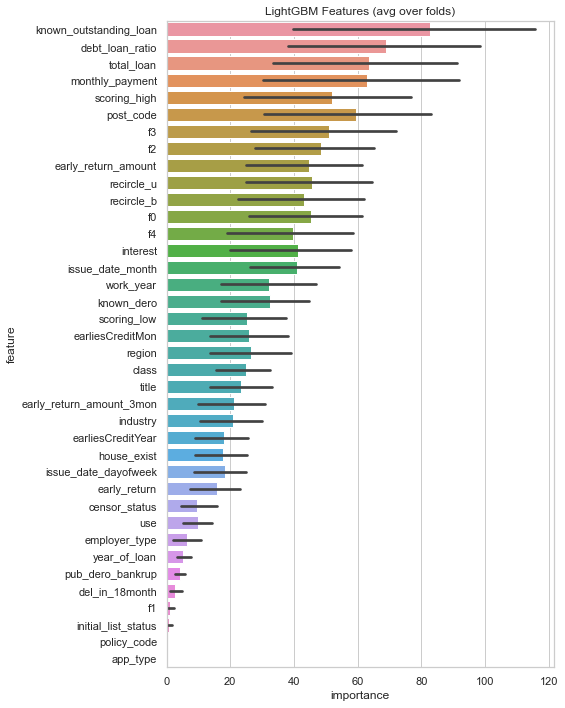

In [77]:
display_importances(importances, fname='lgbm_importances_1.png')

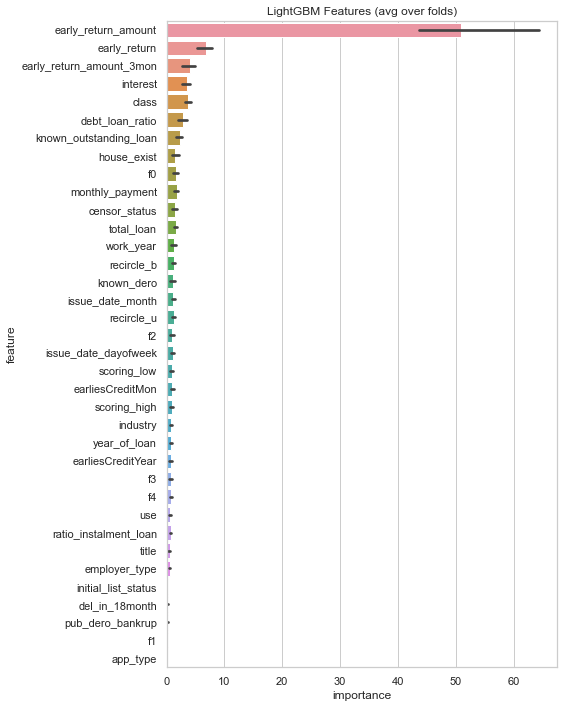

In [22]:
display_importances(importances, fname='catboost_importances.png')

In [51]:
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

print(len(InteId))

# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0

train_data['dataSource'] = 1
test_public['dataSource'] = 1
data_cols_train_inte_public_same['dataSource'] = 0

data_cols_train_inte_public_same['isDefault'] = train_inte['is_default']

use_te = data_cols_train_inte_public_same[data_cols_train_inte_public_same.loan_id.isin( InteId )].copy()

# 合并各来源的数据集
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)



In [44]:
data.head()

,app_type,censor_status,class,dataSource,debt_loan_ratio,del_in_18month,earliesCreditMon,earliesCreditYear,early_return,early_return_amount,early_return_amount_3mon,employer_type,f0,f1,f2,f3,f4,house_exist,industry,initial_list_status,interest,isDefault,issue_date_dayofweek,issue_date_month,known_dero,known_outstanding_loan,loan_id,monthly_payment,policy_code,post_code,pub_dero_bankrup,recircle_b,recircle_u,region,scoring_high,scoring_low,title,total_loan,use,user_id,work_year,year_of_loan
0,0.000,1,3,1,2.430,0.000,12,2001,3,9927,0.000,3,1.000,0.000,4.000,5.000,4.000,0,13,0,11.466,0.000,5,10,0.000,3.000,1040418,1174.910,1.000,193.000,0.000,7734.231,91.800,13,649.091,556.364,5.000,31818.182,2,240418,3,3
1,0.000,2,3,1,11.005,1.000,4,1990,0,0,0.000,3,7.000,0.000,4.000,45.000,22.000,0,13,1,16.841,0.000,5,6,0.000,3.000,1025197,670.690,1.000,491.000,0.000,31329.000,54.800,30,893.750,715.000,40642.000,28000.000,0,225197,10,5
2,0.000,0,1,1,6.409,0.000,10,1991,0,0,0.000,3,6.000,0.000,6.000,28.000,19.000,1,3,1,8.900,0.000,2,1,0.000,5.000,1009360,603.320,1.000,459.000,0.000,18514.000,57.692,8,903.636,774.545,154.000,17272.727,4,209360,10,3
3,0.000,1,1,1,9.205,0.000,6,2001,0,0,0.000,1,5.000,0.000,10.000,15.000,9.000,0,10,0,4.788,0.000,2,7,0.000,3.000,1039708,602.300,1.000,157.000,0.000,20707.000,42.600,8,875.000,750.000,0.000,20000.000,0,239708,6,3
4,0.000,1,3,1,15.578,0.000,5,2001,0,0,0.000,3,10.000,0.000,6.000,15.000,4.000,2,2,0,12.790,0.000,4,7,0.000,15.000,1027483,470.310,1.000,38.000,0.000,14016.154,30.462,21,710.606,609.091,0.000,15272.727,0,227483,0,3


In [38]:
data['dataSource'].value_counts() # 0: public, 1: internet

0    59829
1    15000
Name: dataSource, dtype: int64

## 模型训练与评估

### 用将train_internet的预测结果和原训练集整合后的数据训练模型，捕捉不同业务当中客户背景信息和违约行为的关联

In [53]:
from sklearn.model_selection import train_test_split

# 定义新的训练和测试集

train = data[data['isDefault'].notna()]

print(f'Size of training set: {len(train)}')

test  = data[data['isDefault'].isna()]

print(f'Size of testing set: {len(test)}')

print("train/test ratio = {:.2f}".format(len(train)/len(test)))

del data
del train_data,test_public

Size of training set: 11532
Size of testing set: 5000
train/test ratio = 2.31


In [54]:
# 用catboost训练基于xgboost预训练的模型

y = train['isDefault']
train = train.drop('isDefault',axis=1)
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds) # Use the training set to predict the labels in the testing set

0:	test: 0.8512112	test1: 0.8617023	best: 0.8617023 (0)	total: 61.2ms	remaining: 3m 3s
50:	test: 0.9088145	test1: 0.9194934	best: 0.9194934 (50)	total: 261ms	remaining: 15.1s
100:	test: 0.9088686	test1: 0.9194540	best: 0.9194934 (50)	total: 437ms	remaining: 12.5s
150:	test: 0.9084712	test1: 0.9190145	best: 0.9194934 (50)	total: 624ms	remaining: 11.8s
200:	test: 0.9087397	test1: 0.9193270	best: 0.9194934 (50)	total: 854ms	remaining: 11.9s
250:	test: 0.9091765	test1: 0.9198934	best: 0.9198934 (250)	total: 1.1s	remaining: 12s
300:	test: 0.9099567	test1: 0.9203285	best: 0.9203285 (300)	total: 1.42s	remaining: 12.7s
350:	test: 0.9105997	test1: 0.9209037	best: 0.9209037 (350)	total: 1.74s	remaining: 13.1s
400:	test: 0.9115653	test1: 0.9219155	best: 0.9219155 (400)	total: 2s	remaining: 13s
450:	test: 0.9121083	test1: 0.9223695	best: 0.9223695 (450)	total: 2.23s	remaining: 12.6s
500:	test: 0.9128883	test1: 0.9231667	best: 0.9231667 (500)	total: 2.42s	remaining: 12.1s
550:	test: 0.9132259	test1

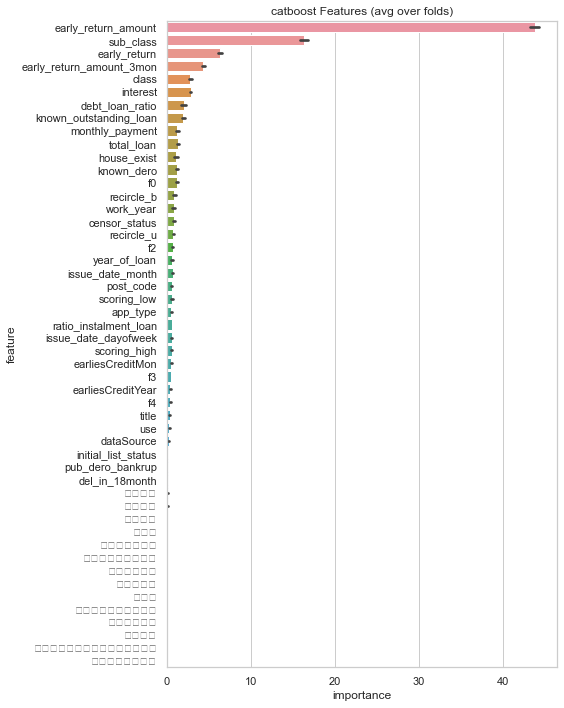

In [61]:
display_importances(importances, fname='catboost_importances_xgboost+catboost.png')

### 输出结果

In [55]:
test_preds.head()

,loan_id,isDefault
10000,1000575,0.039
10001,1028125,0.067
10002,1010694,0.022
10003,1026712,0.018
10004,1002895,0.030


In [58]:
submission_date = '211118'
process(test_preds.rename({'loan_id': 'id'}, axis=1)[['id','isDefault']],3).to_csv(f'./submit/submission_{submission_date}.csv', index=False)